### Why do some people cheat on their spouses?

In 1978, a survey was conducted on housewives in order to discern factors that lead them to pursue extra-marital affairs. This study became the basis for many future studies of both men and women, all attempting to focus on features of people and marriages that led either partner to seek partners elsewhere behind their spouse's back.

Supervised learning is not always about prediction. In this case study, the most important factors that might lead someone to pursue an affair will be identified.

In [1]:
# Using dataset of a 1978 survey conducted to measure likliehood of women to perform extramarital affairs
# http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html

import statsmodels.api as sm
affairs_df = sm.datasets.fair.load_pandas().data
affairs_df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


Quantitative response is identified, but the question is simply what factors cause someone to have an affair. The exact number of minutes or hours does not really matter that much. For this reason, let's make a new categorical variable called affair_binary, which is either true (they had an affair for more than 0 minutes) or false (they had an affair for 0 minutes):

In [2]:
# Create a categorical variable
affairs_df['affair_binary'] = (affairs_df['affairs'] > 0)

Let's start with a simple correlation matrix. Recall that this matrix shows us linear correlations between our quantitative variables and our response. The correlation matrix as both a matrix of decimals and also as a heat map is shown below.

In [3]:
# find linear correlations between variables and affair_binary
affairs_df.corr()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair_binary
rate_marriage,1.000000,-0.111127,-0.128978,-0.129161,0.078794,0.079869,0.039528,0.027745,-0.178068,-0.331776
age,-0.111127,1.000000,0.894082,0.673902,0.136598,0.027960,0.106127,0.162567,-0.089964,0.146519
yrs_married,-0.128978,0.894082,1.000000,0.772806,0.132683,-0.109058,0.041782,0.128135,-0.087737,0.203109
children,-0.129161,0.673902,0.772806,1.000000,0.141845,-0.141918,-0.015068,0.086660,-0.070278,0.159833
religious,0.078794,0.136598,0.132683,0.141845,1.000000,0.032245,0.035746,0.004061,-0.125933,-0.129299
educ,0.079869,0.027960,-0.109058,-0.141918,0.032245,1.000000,0.382286,0.183932,-0.017740,-0.075280
occupation,0.039528,0.106127,0.041782,-0.015068,0.035746,0.382286,1.000000,0.201156,0.004469,0.028981
occupation_husb,0.027745,0.162567,0.128135,0.086660,0.004061,0.183932,0.201156,1.000000,-0.015614,0.017637
affairs,-0.178068,-0.089964,-0.087737,-0.070278,-0.125933,-0.017740,0.004469,-0.015614,1.000000,0.464046
affair_binary,-0.331776,0.146519,0.203109,0.159833,-0.129299,-0.075280,0.028981,0.017637,0.464046,1.000000


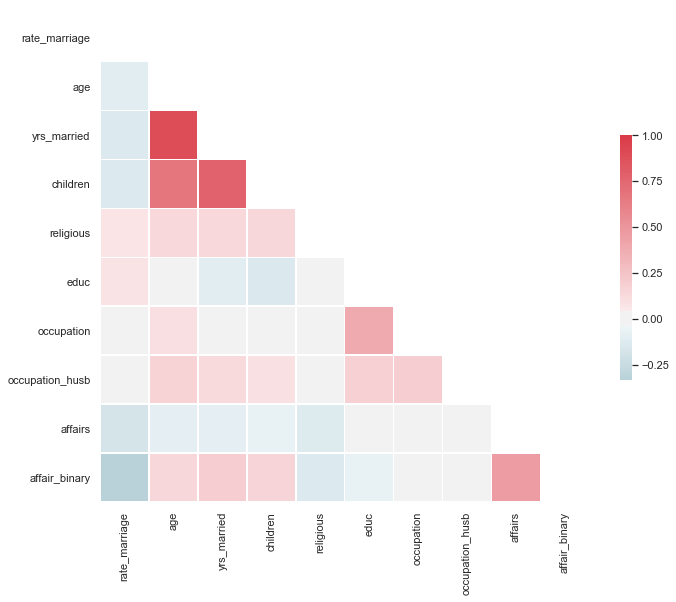

In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = affairs_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

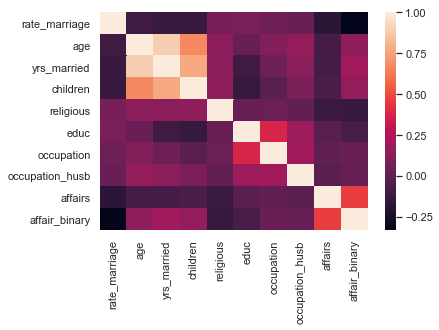

In [5]:
sns.heatmap(affairs_df.corr());

Correlations are not the only way to identify which features are associated with our response. This method shows us how linearly correlated the variables are with each other.

Another variable that affects affairs may be found by evaluating the coefficients of a decision tree classifier. These methods might reveal new variables that are associated with our variables, but not in a linear fashion.

In [6]:
# data without the affairs or affair_binary column
affairs_X = affairs_df.drop(['affairs', 'affair_binary'], axis=1)
affairs_y = affairs_df['affair_binary']

In [7]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model
model = DecisionTreeClassifier()

# import our cross validation module
from sklearn.model_selection import cross_val_score

# check the accuracy on the training set
scores = cross_val_score(model, affairs_X, affairs_y, cv=10)
print(scores.mean(), "average accuracy")
print(scores.std(), "standard deviation") 

# very low, meaning variance of the model is low
# Looks ok on the cross validation side

0.6607016817491769 average accuracy
0.018662749254994806 standard deviation


Because our standard deviation is low we may make the assumption that the variance of our model is low (because variance is the square of standard deviation). This is good because that means that our model is not fitting wildly differently on each fold of the cross-validation and it is generally a reliable model.

Because we agree that our decision tree classifier is generally a reliable model, we can fit the tree to our entire dataset and use the importance metric to identify which variables our tree deemed the most important.

In [8]:
# Explore individual features that make the biggest impact
# rate_marriage, yrs_married, and occupation_husb. 
# But one of these variables doesn't quite make sense right?
# Its the occupation variable, because they are nominal, their interpretations
import pandas as pd
model.fit(affairs_X, affairs_y)
#pd.DataFrame({'feature':affairs_X.columns, 'importance':model.feature_importances_}).sort('importance').tail(3)
pd.DataFrame({'feature':affairs_X.columns, 'importance':model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
7,occupation_husb,0.179997
0,rate_marriage,0.141012
3,children,0.132650
2,yrs_married,0.130592
5,educ,0.121710
1,age,0.108862
6,occupation,0.093999
4,religious,0.091179


So, "yrs_married" and "rate_marriage" both are important, but the most important variable is "occupation_husb". But that doesn't make sense because that variable is nominal!

Now, let's apply our dummy variable technique wherein we create new columns that represent each option for occupation_husb and also for occupation.

In [9]:
# Dummy Variables:
# Encoding qualitiative (nominal) data using separate columns 
#(see slides for linear regression for more)
occuptation_dummies = pd.get_dummies(affairs_df['occupation'], prefix='occ_').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame
# (axis=0 means rows, axis=1 means columns)
affairs_df = pd.concat([affairs_df, occuptation_dummies], axis=1)
affairs_df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair_binary,occ__2.0,occ__3.0,occ__4.0,occ__5.0,occ__6.0
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,True,1,0,0,0,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,True,0,1,0,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,True,0,1,0,0,0
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,True,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,True,0,1,0,0,0


In [10]:
# Now for the husband's job
occuptation_dummies = pd.get_dummies(affairs_df['occupation_husb'], prefix='occ_husb_').iloc[:, 1:]

# concatenate the dummy variable columns onto the original DataFrame
#(axis=0 means rows, axis=1 means columns)
affairs_df = pd.concat([affairs_df, occuptation_dummies], axis=1)
affairs_df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair_binary,occ__2.0,occ__3.0,occ__4.0,occ__5.0,occ__6.0,occ_husb__2.0,occ_husb__3.0,occ_husb__4.0,occ_husb__5.0,occ_husb__6.0
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,True,1,0,0,0,0,0,0,0,1,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,True,0,1,0,0,0,0,0,1,0,0
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,True,0,1,0,0,0,0,0,0,1,0
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,True,0,0,0,1,0,0,0,0,1,0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,True,0,1,0,0,0,0,0,1,0,0


Now we have 15 new columns! Let's run our tree again and find the most important variables:

In [11]:
# remove appropiate columns for feature set
affairs_X = affairs_df.drop(['affairs', 'affair_binary', 'occupation', 'occupation_husb'], axis=1)
affairs_y = affairs_df['affair_binary']

# instantiate the model
model = DecisionTreeClassifier()

# check the accuracy on the training set
scores = cross_val_score(model, affairs_X, affairs_y, cv=10)
print(scores.mean(), "average accuracy")
print(scores.std(), "standard deviation") 

# very low, meaning variance of the model is low
# Looks ok on the cross validation side

0.6528351176041481 average accuracy
0.02375686212046328 standard deviation


In [12]:
# Explore individual features that make the biggest impact
model.fit(affairs_X, affairs_y)
pd.DataFrame({'feature':affairs_X.columns, 'importance':model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,rate_marriage,0.139721
2,yrs_married,0.133757
3,children,0.132126
5,educ,0.129339
1,age,0.112010
4,religious,0.099467
13,occ_husb__4.0,0.044933
14,occ_husb__5.0,0.041982
11,occ_husb__2.0,0.033457
15,occ_husb__6.0,0.026370


These seem to be the top five most important variables in determining whether or not a woman from the 1978 survey would be involved in an extramarital affair.